## Multilayer perceptron (MLP) - the Machine Learning Workflow

A typical machine learning approach consists of several steps that can be arranged in a kind of standard workflow. Training of the model, which we have done in the previous examples of different algorithms, is only a small part of this workflow. Data preprocessing and model evaluation and selection are by far the more extensive tasks.

In the following we will walk through the entire workflow using a simple but more realistic example than using toy data.

Our goal is to use weather data and predict the daily mean temperature at a measurement station from several other measurements, such as pressure, vapor content, and so on.

For this example, we will use a daily time series from the DWD weather station Berlin-Dahlem (FU), downloaded from [Climate Data Center](https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/daily/kl/historical/tageswerte_KL_00403_19500101_20211231_hist.zip) on 2022-07-22. A detailed description of the variables is available [here](https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/daily/kl/historical/DESCRIPTION_obsgermany_climate_daily_kl_historical_en.pdf). For the purpose of this tutorial the dataset is provided [here](https://userpage.fu-berlin.de/soga/data/raw-data/tageswerte_KL_00403_19500101_20211231_hist.zip).

### Read dataset

In [1]:
%load_ext lab_black

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

After defining some some basic libraries, we start by downloading the data, extracting the zip file, and reading the data into a Pandas data frame.

In [3]:
import requests, zipfile, io

url = "http://userpage.fu-berlin.de/soga/soga-py/300/307000_time_series/tageswerte_KL_00403_19500101_20211231_hist.zip"
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extract("produkt_klima_tag_19500101_20211231_00403.txt", "../data")
data_raw = pd.read_csv(
    "../data/produkt_klima_tag_19500101_20211231_00403.txt",
    sep=";",
    na_values=["-999"],
    skipinitialspace=True,
)
data_raw

,STATIONS_ID,MESS_DATUM,QN_3,FX,FM,QN_4,RSK,RSKF,SDK,SHK_TAG,NM,VPM,PM,TMK,UPM,TXK,TNK,TGK,eor
0,403,19500101,NaN,NaN,NaN,5,2.2,7,NaN,0.0,5.0,4.0,1025.60,-3.2,83.00,-1.1,-4.9,-6.3,eor
1,403,19500102,NaN,NaN,NaN,5,12.6,8,NaN,0.0,8.0,6.1,1005.60,1.0,95.00,2.2,-3.7,-5.3,eor
2,403,19500103,NaN,NaN,NaN,5,0.5,1,NaN,0.0,5.0,6.5,996.60,2.8,86.00,3.9,1.7,-1.4,eor
3,403,19500104,NaN,NaN,NaN,5,0.5,7,NaN,0.0,7.7,5.2,999.50,-0.1,85.00,2.1,-0.9,-2.3,eor
4,403,19500105,NaN,NaN,NaN,5,10.3,7,NaN,0.0,8.0,4.0,1001.10,-2.8,79.00,-0.9,-3.3,-5.2,eor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26293,403,20211227,NaN,NaN,NaN,3,0.0,8,0.183,0.0,5.9,3.8,998.13,-3.7,79.67,-0.7,-7.9,-9.9,eor
26294,403,20211228,NaN,NaN,NaN,3,1.5,6,0.000,0.0,6.4,5.3,990.17,-0.5,88.46,2.7,-3.9,-5.1,eor
26295,403,20211229,NaN,NaN,NaN,3,0.3,6,0.000,0.0,7.5,8.2,994.40,4.0,100.00,5.6,1.8,0.0,eor
26296,403,20211230,NaN,NaN,NaN,3,3.2,6,0.000,0.0,7.9,11.5,1001.70,9.0,98.54,12.7,4.6,2.3,eor


### Remove unnecessary columns

By looking at the data and consulting the variable description, we can immediately find variables that are not useful for our purpose and drop them.
- STATIONS_ID -> There is only one station in the data.
- MESS_DATUM -> Since we are not interested in a time series analysis, this is just a numbering of the rows.
- QN_3, FX, FM, eor -> These variables do not contain any data.
- QN_4 -> This value is a data quality label and has no relation to weather data.

In [4]:
data = data_raw.drop(
    columns=["STATIONS_ID", "MESS_DATUM", "QN_3", "FX", "FM", "NM", "eor", "QN_4"]
)
data

,RSK,RSKF,SDK,SHK_TAG,VPM,PM,TMK,UPM,TXK,TNK,TGK
0,2.2,7,NaN,0.0,4.0,1025.60,-3.2,83.00,-1.1,-4.9,-6.3
1,12.6,8,NaN,0.0,6.1,1005.60,1.0,95.00,2.2,-3.7,-5.3
2,0.5,1,NaN,0.0,6.5,996.60,2.8,86.00,3.9,1.7,-1.4
3,0.5,7,NaN,0.0,5.2,999.50,-0.1,85.00,2.1,-0.9,-2.3
4,10.3,7,NaN,0.0,4.0,1001.10,-2.8,79.00,-0.9,-3.3,-5.2
...,...,...,...,...,...,...,...,...,...,...,...
26293,0.0,8,0.183,0.0,3.8,998.13,-3.7,79.67,-0.7,-7.9,-9.9
26294,1.5,6,0.000,0.0,5.3,990.17,-0.5,88.46,2.7,-3.9,-5.1
26295,0.3,6,0.000,0.0,8.2,994.40,4.0,100.00,5.6,1.8,0.0
26296,3.2,6,0.000,0.0,11.5,1001.70,9.0,98.54,12.7,4.6,2.3


### Rename columns for convenience

To improve the readability, we rename the remaining columns.

In [5]:
data = data.rename(
    columns={
        "RSK": "prec",
        "RSKF": "prec_type",
        "SDK": "sun_dur",
        "SHK_TAG": "snow_depth",
        "VPM": "vapor_pres",
        "PM": "pres",
        "TMK": "temp",
        "UPM": "rel_humid",
        "TXK": "temp_max",
        "TNK": "temp_min",
        "TGK": "temp_sfc",
    }
)
data

,prec,prec_type,sun_dur,snow_depth,vapor_pres,pres,temp,rel_humid,temp_max,temp_min,temp_sfc
0,2.2,7,NaN,0.0,4.0,1025.60,-3.2,83.00,-1.1,-4.9,-6.3
1,12.6,8,NaN,0.0,6.1,1005.60,1.0,95.00,2.2,-3.7,-5.3
2,0.5,1,NaN,0.0,6.5,996.60,2.8,86.00,3.9,1.7,-1.4
3,0.5,7,NaN,0.0,5.2,999.50,-0.1,85.00,2.1,-0.9,-2.3
4,10.3,7,NaN,0.0,4.0,1001.10,-2.8,79.00,-0.9,-3.3,-5.2
...,...,...,...,...,...,...,...,...,...,...,...
26293,0.0,8,0.183,0.0,3.8,998.13,-3.7,79.67,-0.7,-7.9,-9.9
26294,1.5,6,0.000,0.0,5.3,990.17,-0.5,88.46,2.7,-3.9,-5.1
26295,0.3,6,0.000,0.0,8.2,994.40,4.0,100.00,5.6,1.8,0.0
26296,3.2,6,0.000,0.0,11.5,1001.70,9.0,98.54,12.7,4.6,2.3


### Remove correlated columns

In the next step, we see that there are four columns with temperature-related data:
- TMK -> Daily Mean Temp (this is the temperature which we want to predict)
- TXK -> Daily Max Temp at 2m
- TNK -> Daily Min Temp at 2m
- TGK -> Daily Min Temp at 5cm

The following pair plot shows that these values are highly correlated, as expected.

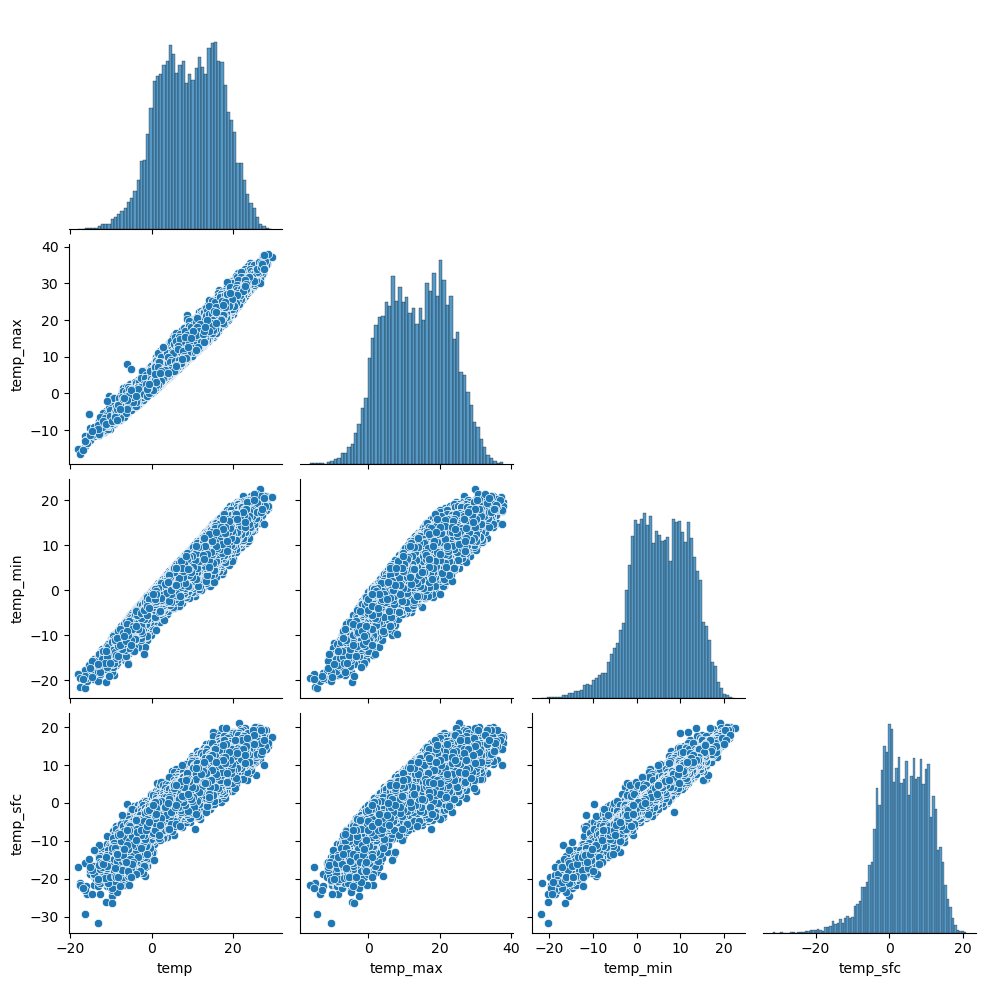

In [6]:
sns.pairplot(data, vars=["temp", "temp_max", "temp_min", "temp_sfc"], corner=True)

Our goal is to predict the mean temperature (temp). If we leave the other temperature variables in the data set, our model will basically use these correlations and thus ignore all other variables. So we will drop temp_max, temp_min, and temp_sfc.

Note: If our target variable were something other than temperature, we would effectively have four correlated predictor variables. This could lead to a high influence on the model. It might then be useful to reduce this influence by dimensionally reducing the feature space. One way is to drop certain features, as we do here, another way can be a **principle component analysis (PCA)** where only the main components are kept in the analysis.

In [7]:
data = data.drop(columns=["temp_max", "temp_min", "temp_sfc"])
data

,prec,prec_type,sun_dur,snow_depth,vapor_pres,pres,temp,rel_humid
0,2.2,7,NaN,0.0,4.0,1025.60,-3.2,83.00
1,12.6,8,NaN,0.0,6.1,1005.60,1.0,95.00
2,0.5,1,NaN,0.0,6.5,996.60,2.8,86.00
3,0.5,7,NaN,0.0,5.2,999.50,-0.1,85.00
4,10.3,7,NaN,0.0,4.0,1001.10,-2.8,79.00
...,...,...,...,...,...,...,...,...
26293,0.0,8,0.183,0.0,3.8,998.13,-3.7,79.67
26294,1.5,6,0.000,0.0,5.3,990.17,-0.5,88.46
26295,0.3,6,0.000,0.0,8.2,994.40,4.0,100.00
26296,3.2,6,0.000,0.0,11.5,1001.70,9.0,98.54


### Drop missing data

As a next step, we check the data for missing values.

In [8]:
data.isnull().sum()

prec            0
prec_type       0
sun_dur       145
snow_depth      1
vapor_pres      1
pres            0
temp            0
rel_humid       1
dtype: int64

As we can see, the percentage of missing values in our data is very small (148 out of 26298 rows). Therefore, the simplest solution is to simply drop all rows with missing data. If the percentage were higher, other solutions might be more useful, such as **imputing values** for the missing values.

In [9]:
data.dropna(axis=0, inplace=True)
data

,prec,prec_type,sun_dur,snow_depth,vapor_pres,pres,temp,rel_humid
90,1.0,1,0.000,0.0,7.1,1001.50,7.1,70.00
91,2.8,1,0.000,0.0,8.7,984.70,7.6,81.00
92,0.0,0,6.400,0.0,6.7,987.80,6.9,68.00
93,0.5,1,5.800,0.0,6.9,997.20,6.2,73.00
94,11.7,1,2.900,0.0,7.1,1000.70,6.4,74.00
...,...,...,...,...,...,...,...,...
26293,0.0,8,0.183,0.0,3.8,998.13,-3.7,79.67
26294,1.5,6,0.000,0.0,5.3,990.17,-0.5,88.46
26295,0.3,6,0.000,0.0,8.2,994.40,4.0,100.00
26296,3.2,6,0.000,0.0,11.5,1001.70,9.0,98.54


### Handle categorical data

All of the data in our data set contain numerical values. However, while they are all continuous variables, the prec_type is a categorical variable. Furthermore, it is only nominal, not ordinal. If we leave the values as they are, the model will imply an order on the prec_type, assuming for example that type 8 is greater than type 6. This could lead to non-optimal results.

We will use a solution called **one-hot encoding**. This means that we create a new feature for each of the types and assign binary values to it.

In [10]:
data["prec_type"] = data["prec_type"].apply(str)
data = pd.get_dummies(data, drop_first=True)
data

,prec,sun_dur,snow_depth,vapor_pres,pres,temp,rel_humid,prec_type_1,prec_type_4,prec_type_6,prec_type_7,prec_type_8
90,1.0,0.000,0.0,7.1,1001.50,7.1,70.00,True,False,False,False,False
91,2.8,0.000,0.0,8.7,984.70,7.6,81.00,True,False,False,False,False
92,0.0,6.400,0.0,6.7,987.80,6.9,68.00,False,False,False,False,False
93,0.5,5.800,0.0,6.9,997.20,6.2,73.00,True,False,False,False,False
94,11.7,2.900,0.0,7.1,1000.70,6.4,74.00,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
26293,0.0,0.183,0.0,3.8,998.13,-3.7,79.67,False,False,False,False,True
26294,1.5,0.000,0.0,5.3,990.17,-0.5,88.46,False,False,True,False,False
26295,0.3,0.000,0.0,8.2,994.40,4.0,100.00,False,False,True,False,False
26296,3.2,0.000,0.0,11.5,1001.70,9.0,98.54,False,False,True,False,False


Note: We used the option `drop_first=True` which removes the column for the first type. This does not reduce the information because the precipitation is of type 0 if it is not of another type, but it does reduce the number of features we introduce.

### Inspect data

Now that all the data is preprocessed, we want to take a closer look at the different features. We will start by plotting the distributions.

#### Check distributions

array([[<Axes: title={'center': 'prec'}>,
        <Axes: title={'center': 'sun_dur'}>,
        <Axes: title={'center': 'snow_depth'}>],
       [<Axes: title={'center': 'vapor_pres'}>,
        <Axes: title={'center': 'pres'}>,
        <Axes: title={'center': 'rel_humid'}>],
       [<Axes: title={'center': 'temp'}>, <Axes: >, <Axes: >]],
      dtype=object)

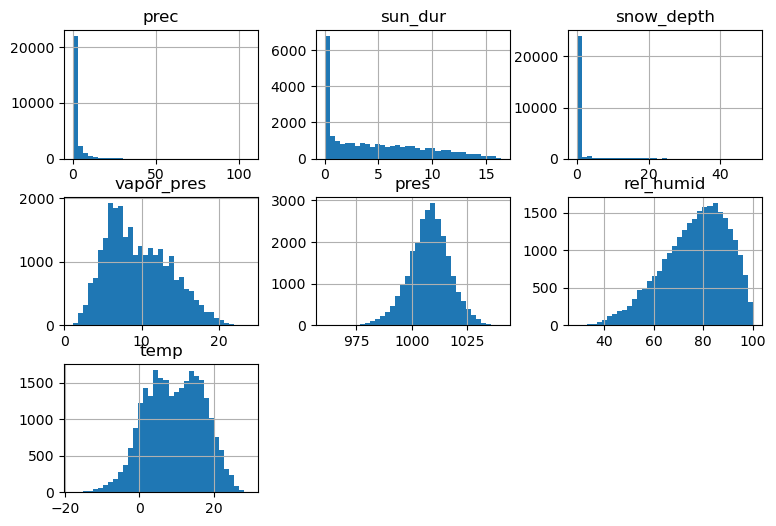

In [11]:
data[["prec", "sun_dur", "snow_depth", "vapor_pres", "pres", "rel_humid", "temp"]].hist(
    bins=35, figsize=(9, 6)
)

In [12]:
data[
    ["prec", "sun_dur", "snow_depth", "vapor_pres", "pres", "rel_humid", "temp"]
].describe()

,prec,sun_dur,snow_depth,vapor_pres,pres,rel_humid,temp
count,26152.000000,26152.000000,26152.000000,26152.000000,26152.000000,26152.000000,26152.000000
mean,1.605422,4.741813,0.754742,9.599373,1007.798212,76.528964,9.374013
std,3.854016,4.429256,3.293229,4.084277,9.128905,12.914631,7.619309
min,0.000000,0.000000,0.000000,1.100000,961.000000,29.000000,-17.900000
25%,0.000000,0.400000,0.000000,6.400000,1002.297500,68.000000,3.600000
50%,0.000000,3.800000,0.000000,8.900000,1008.200000,78.000000,9.500000
75%,1.500000,8.000000,0.000000,12.500000,1013.600000,87.000000,15.400000
max,106.000000,16.400000,49.000000,23.900000,1040.000000,100.000000,29.500000


We can see several things here. Let us start with precipitation, sunshine duration and snow depth. All three show a large spike at 0. This indicates a problem with the data. Here, 0 means that there was no precipitation, but it could also mean that the precipitation was too low to be measured, or that there was a problem with the instrument. The same is true for sunshine duration. We cannot easily compensate for these problems, so we will drop the information.

We do the same for snow depth, which is 0 most of the time.

In [13]:
data = data.drop(columns=["prec", "sun_dur", "snow_depth"])
data

,vapor_pres,pres,temp,rel_humid,prec_type_1,prec_type_4,prec_type_6,prec_type_7,prec_type_8
90,7.1,1001.50,7.1,70.00,True,False,False,False,False
91,8.7,984.70,7.6,81.00,True,False,False,False,False
92,6.7,987.80,6.9,68.00,False,False,False,False,False
93,6.9,997.20,6.2,73.00,True,False,False,False,False
94,7.1,1000.70,6.4,74.00,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...
26293,3.8,998.13,-3.7,79.67,False,False,False,False,True
26294,5.3,990.17,-0.5,88.46,False,False,True,False,False
26295,8.2,994.40,4.0,100.00,False,False,True,False,False
26296,11.5,1001.70,9.0,98.54,False,False,True,False,False


Next we look at the distribution for cloud cover. Cloud cover is measured in eighths, which actually makes it a discrete variable. However, here we have daily averages, so we get pseudo-continuous values. But there is still no real metric, so we convert the cloud cover to a percentage.

Finally, we see that the distributions for cloud cover, vapor pressure, pressure, relative humidity, and temperature are all on different scales and are not normally distributed. However, many learning algorithms rely on gradient descent or distance measures. This is problematic when the values are on very different scales. Furthermore, most features are bounded on one or even both sides, so that values outside these bounds are physically meaningless. In the following, we will apply some transformations to the features.

**But before we do that, we need to take another important step first.**

### Train-Test split

When we train a model, we need to test its performance. To do this, we need data that is similar to the training data, but independent of it. We achieve this by splitting our dataset into two parts, a training part, which we use to build the model, and a test part, which we use only for the final evaluation.

Here we use 80% of our data for training and 20% for testing. Additionally, we split the data into features and target variables.

In [14]:
from sklearn.model_selection import train_test_split

# split features and target first
X, y = data.drop(columns=["temp"]), data["temp"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print(len(X_train), len(X_test), len(y_train), len(y_test))

20921 5231 20921 5231


As we can see, we have 20921 records in the training set and 5231 records in the test set.

Note: The records are randomly shuffled and split to avoid any effects from the original order of the records.

### Feature scaling

Now we are ready for the promised feature scaling.

The reason we did the train-test split first is that we want a pure training data set that is not influenced by the test data. If we were to determine the scaling parameters from the whole data set, information from the test data would be included in the parameters. Therefore, we perform the scaling on the training data only. Then, of course, we have to transform the test set with the same parameters.

The features cloud cover, vapor pressure, pressure, relative humidity and temperature are all double constrained and we will use a logistic transformation with a prior min-max scaling.

#### Min-Max scaling

The min-max scaling

$$x'=\frac{x-x_{min}}{x_{max}-x_{min}}$$


transforms the data into the range $[0,1]$. We want to avoid getting values with 0, because in the second step we need the logarithm of the values. Therefore, we use slightly larger boundary values $x_{min}-1$ and $x_{max}+1$. Thus

$$x'=\frac{x-x_{min}+1}{x_{max}-x_{min}+2\, .}$$


**Note that we transform the test set with the min max values from the train set.**


In [15]:
transform_cols = ["vapor_pres", "pres", "rel_humid"]
X_test[transform_cols] = (
    X_test[transform_cols] - X_train[transform_cols].min() + 1
) / (X_train[transform_cols].max() - X_train[transform_cols].min() + 2)
X_train[transform_cols] = (
    X_train[transform_cols] - X_train[transform_cols].min() + 1
) / (X_train[transform_cols].max() - X_train[transform_cols].min() + 2)
y_test = (y_test - y_train.min() + 1) / (y_train.max() - y_train.min() + 2)
y_train = (y_train - y_train.min() + 1) / (y_train.max() - y_train.min() + 2)

#### Logistic transformation

As a second step, we use a logistic transformation
$$x''=\log\frac{x'}{1-x'}$$

However, before we can start the transformation, we face a problem! Because we have transformed the test set with the values of the training set, the test set may contain values outside the range [0,1]. This will not work with the logarithm in the transformation.

In [16]:
print(X_test[X_test[transform_cols].le(0).any(axis=1)])
print(X_test[X_test[transform_cols].ge(1).any(axis=1)])
print(y_test[y_test.le(0)])
print(y_test[y_test.ge(1)])

       vapor_pres      pres  rel_humid  prec_type_1  prec_type_4  prec_type_6  \
14301    0.270161 -0.032258   0.643836        False        False         True   

       prec_type_7  prec_type_8  
14301        False        False  
Empty DataFrame
Columns: [vapor_pres, pres, rel_humid, prec_type_1, prec_type_4, prec_type_6, prec_type_7, prec_type_8]
Index: []
Series([], Name: temp, dtype: float64)
Series([], Name: temp, dtype: float64)


As we can see, there is a pressure value below 0 in the test set. We basically have two options: either drop the data or impute new values. As we only have one problematic data set, we will drop it. For imputation, we could assign the minimum possible value to the problematic pressure value.

In [17]:
y_test.drop(
    X_test[
        X_test[transform_cols].le(0).any(axis=1)
        | X_test[transform_cols].ge(1).any(axis=1)
    ].index,
    inplace=True,
)
X_test.drop(
    X_test[
        X_test[transform_cols].le(0).any(axis=1)
        | X_test[transform_cols].ge(1).any(axis=1)
    ].index,
    inplace=True,
)

In [18]:
X_test.drop(y_test[y_test.le(0) | y_test.ge(1)].index, inplace=True)
y_test.drop(y_test[y_test.le(0) | y_test.ge(1)].index, inplace=True)

Now we are ready for the logistical transformation.

In [19]:
X_test[transform_cols] = np.log(X_test[transform_cols] / (1 - X_test[transform_cols]))
X_train[transform_cols] = np.log(
    X_train[transform_cols] / (1 - X_train[transform_cols])
)
y_test = np.log(y_test / (1 - y_test))
y_train = np.log(y_train / (1 - y_train))

Let's take a look at the new distributions.

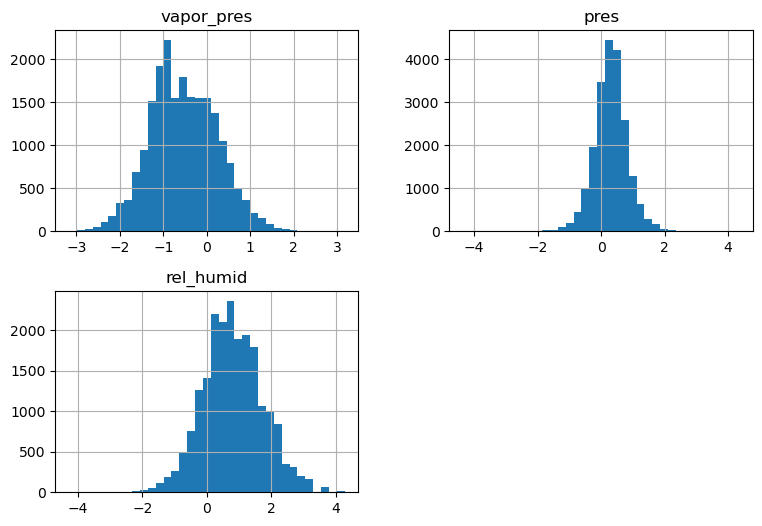

In [20]:
X_train[transform_cols].hist(bins=35, figsize=(9, 6))
plt.show()

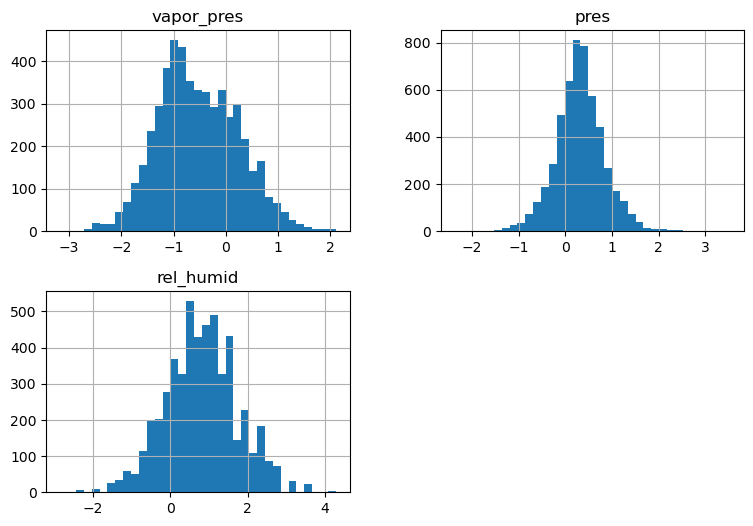

In [21]:
X_test[transform_cols].hist(bins=35, figsize=(9, 6))
plt.show()

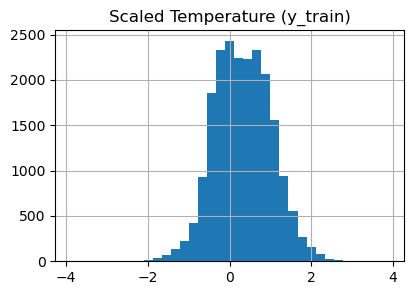

In [22]:
y_train.hist(bins=35, figsize=(4.5, 3))
plt.title("Scaled Temperature (y_train)")
plt.show()

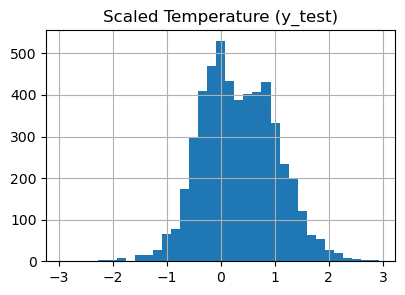

In [23]:
y_test.hist(bins=35, figsize=(4.5, 3))
plt.title("Scaled Temperature (y_test)")
plt.show()

We can see that all the features are now on the same scale and have an almost normal distribution. After the transformation the data is not anymore restricted to a certain interval, and has vaules greater and less than zero. Now we are allowed to use euclidean metrics, i.e. distances and angles, and can apply statistical methods that are based on these metrics.

### Model definition

All the necessary pre-processing is now done and we can finally get to the actual model.

We will use a neural net for this regression task and start with a fully connected net with two layers and 8 nodes each. We chose the 8 simply because we have 8 features.

In [24]:
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(
    hidden_layer_sizes=(
        8,
        8,
    ),
    activation="relu",
    alpha=0.0001,
    batch_size=200,
    max_iter=200,
    random_state=0,
)

### Model training

Once we have defined the model, we need to train it on our train set.

In [25]:
mlp.fit(X_train, y_train)

MLPRegressor(batch_size=200, hidden_layer_sizes=(8, 8), random_state=0)

### Model evaluation

You may have thought "that's it", but we are only halfway through. Having a trained model is nice, but is it a good model, i.e. does it do what it is supposed to do? And how well is it doing it? And could we make the model even better? These questions are answered when we perform model evaluation and model selection.

#### Convergence of training

First, let's look at the training of the model. Within the neural network, we update the weights at the nodes to minimise a loss function. The following graph shows the value of this loss function as a function of epochs, i.e. the number of times the training data set is used.

Text(0, 0.5, 'Loss')

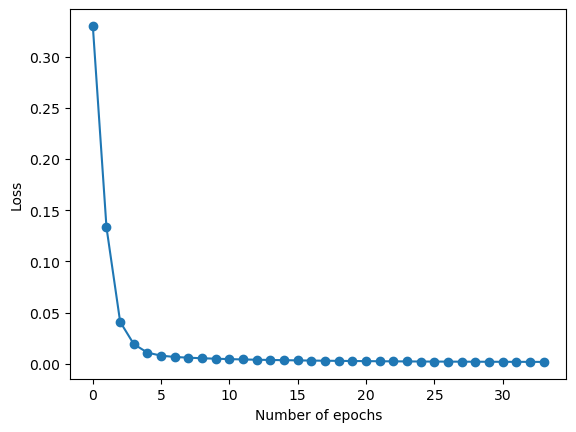

In [26]:
plt.plot(mlp.loss_curve_, marker="o")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")

As expected, the value of the loss function decreases as the number of epochs increases. We also see that after 5 epochs, the gain due to further epochs is minimal. We can therefore conclude that the model has converged to a stable state after a few epochs.

#### Model validation

Let us start with a naive approach to get an idea of the performance of the model. We will use our test data and predict temperatures $\hat{y}_i$ for each of the datasets in `X_test`. Then we compare the model output with our known temperatures $y_i$ in `y_test`. To calculate the  mean squared error
$$MSE={\sum_{i=1}^N\left(y_i-\hat{y}_i\right)^2}\, ,$$ respectively the root mean squared error
$$RMSE=\sqrt{\sum_{i=1}^N\left(y_i-\hat{y}_i\right)^2}$$
gives us an estimate of the quality of the prediction.

In [27]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, mlp.predict(X_test), squared=False)

/opt/anaconda3/envs/jupyter_book_ml/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0.05532913703581025

So what does this figure tell us? The RMSE is the root of the mean of the squared deviations between the prediction and the "truth". So a value of 0.055, or 0.055K in units, is a very good value. So we could conclude that our model is very good.

However, we might be lucky in our choice of training and test data. To reduce the influence of this split, we perform a so-called k-fold cross validation. This means that we take the training data and split it into 10 equal pieces, i.e. $k=10$ here. We then train the model on nine of the 10 pieces and use the 10th piece to validate the model as above. This process is repeated 10 times, each time using a different piece for validation. In the end we get 10 RMSE values which give us some insight into the validity of the above value.

In [28]:
from sklearn.model_selection import cross_val_score

scores = -cross_val_score(
    estimator=mlp,
    X=X_train,
    y=y_train,
    cv=10,
    scoring="neg_mean_squared_error",
    n_jobs=1,
)
print(scores)
print(np.mean(scores), np.std(scores))

[0.00506648 0.00289515 0.00274493 0.00277863 0.00348901 0.00423427
 0.00360007 0.00547693 0.00387099 0.00348136]
0.0037637816379283763 0.0008837386878676765


As we can see, the value of 0.055 is actually at the upper end of the values coming out of the cross-validation.

Note: The function returns the negative RMSE, which we have converted to positive values.

#### Learning curve
An important thing to watch out for in machine learning is **overfitting**. This means that if we train our model well, it will learn all the tiny characteristics of the data and thus describe the training data perfectly. However, the test data may be slightly different, so the model will perform poorly on new data.

One way to detect overfitting is to run a so-called learning curve. This means that we train the model with training sets of different sizes. Furthermore, each training is done with a 10-fold cross validation.

In [29]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    estimator=mlp,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=10,
    scoring="neg_mean_squared_error",
    n_jobs=1,
)
train_scores = -train_scores
test_scores = -test_scores

/opt/anaconda3/envs/jupyter_book_ml/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Again, we changed the sign of the scores to get positive values.

To get some insight into the results, we plot the RMSE value against the size of the training set.

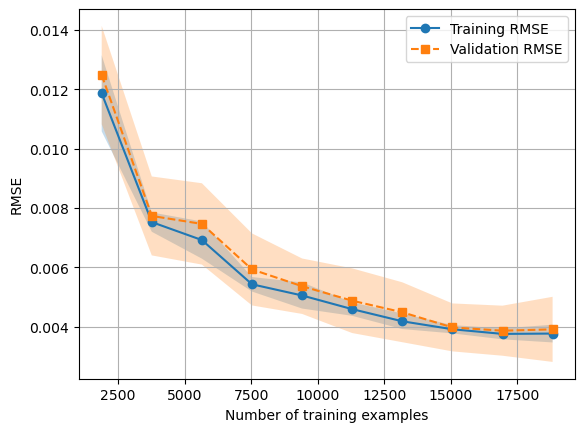

In [31]:
# calculate mean and std
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)


plt.plot(train_sizes, train_mean, marker="o", label="Training RMSE")
plt.fill_between(
    train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.25
)
plt.plot(
    train_sizes, test_mean, linestyle="dashed", marker="s", label="Validation RMSE"
)
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.25)
plt.grid()
plt.xlabel("Number of training examples")
plt.ylabel("RMSE")
plt.legend(loc="upper right")

If we assume overfitting, we would expect the training and validation curves to diverge, or at least to have an offset, because the training value would be better, i.e. smaller, than the validation value. Here, however, both lines agree for the large training set sizes. We can therefore conclude that there is no overfitting in our model.

### Model selection

In the previous part, we checked the model for problems such as poor performance and overfitting. In this part we will see if we can improve the model by changing so-called hyperparameters, i.e. parameters that are used for the model but are not related to the data.

#### Parameter alpha

In our model definition we set the parameter alpha to 0.0001. This parameter controls the so-called **L2 regularisation**, which adds a penalty term to the loss function to prevent the weights from diverging.

To get an idea of the influence of the alpha parameter, we perform several model fits with different values for alpha. Again, a 10-fold cross-validation is performed for each of the fits.

In [32]:
from sklearn.model_selection import validation_curve

alphas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]

train_scores, test_scores = validation_curve(
    estimator=mlp,
    X=X_train,
    y=y_train,
    param_name="alpha",
    param_range=alphas,
    cv=10,
    scoring="neg_mean_squared_error",
)

train_scores = -train_scores
test_scores = -test_scores

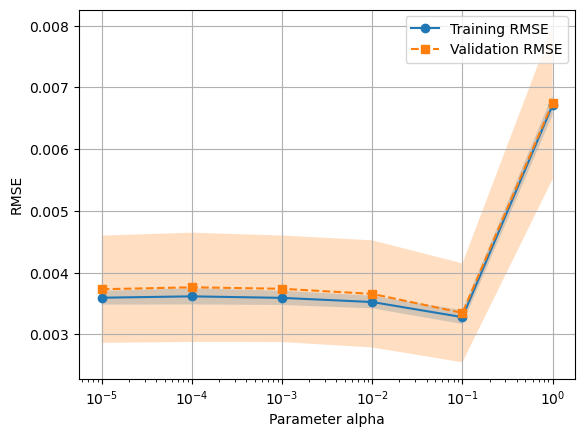

In [33]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(alphas, train_mean, marker="o", label="Training RMSE")
plt.fill_between(alphas, train_mean + train_std, train_mean - train_std, alpha=0.25)
plt.plot(alphas, test_mean, linestyle="dashed", marker="s", label="Validation RMSE")
plt.fill_between(alphas, test_mean + test_std, test_mean - test_std, alpha=0.25)
plt.grid()
plt.xscale("log")
plt.legend(loc="upper right")
plt.xlabel("Parameter alpha")
plt.ylabel("RMSE")
plt.show()

The plot shows that over a wide range of alpha values the result for the model is almost the same. However, for larger values, the RMSE starts to "jump around". Since we are not sure whether the lower value for $alpha=0.1$ is just lower by chance or really a better value, we stick with our predefined value of 0.0001.

#### The network layout

We have defined the layout for our model as two layers of 9 nodes each. This was a very arbitrary choice and we will now test some different layouts and see if they offer better performance. So we define different layouts:

1. two layers of 8 nodes each (our original model)
2. one layer with 8 nodes and a second with 4 nodes
3. a single layer of 8 nodes
4. one layer of 100 nodes (the default in Sklearn)
5. one layer of 100, then 50 and 25 nodes

and test each with a 10-fold cross validation.

In [34]:
from sklearn.model_selection import validation_curve

layouts = [
    (
        8,
        8,
    ),
    (
        8,
        4,
    ),
    (8,),
    (100,),
    (
        100,
        50,
        25,
    ),
]

train_scores, test_scores = validation_curve(
    estimator=mlp,
    X=X_train,
    y=y_train,
    param_name="hidden_layer_sizes",
    param_range=layouts,
    cv=10,
    scoring="neg_mean_squared_error",
)

train_scores = -train_scores
test_scores = -test_scores

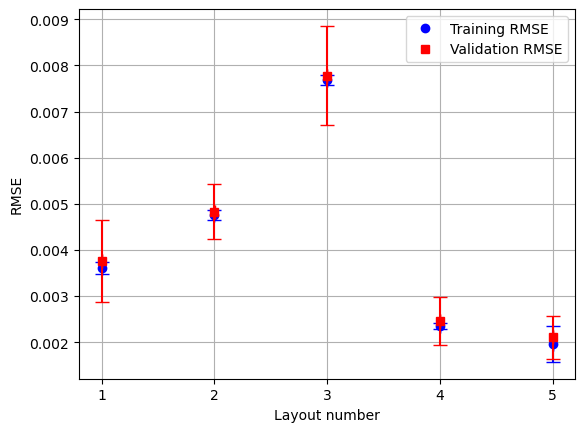

In [35]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

layout = [1, 2, 3, 4, 5]
plt.plot(
    layout,
    train_mean,
    marker="o",
    color="blue",
    linestyle="None",
    label="Training RMSE",
)
plt.errorbar(
    layout, train_mean, train_std, train_std, capsize=5, color="blue", linestyle="None"
)
plt.plot(
    layout,
    test_mean,
    marker="s",
    color="red",
    linestyle="None",
    label="Validation RMSE",
)
plt.errorbar(
    layout, test_mean, test_std, test_std, capsize=5, color="red", linestyle="None"
)
plt.grid()
plt.legend(loc="upper right")
plt.xlabel("Layout number")
plt.ylabel("RMSE")
plt.xticks(layout)
plt.show()

There is an obvious difference between layouts. Layouts with more nodes perform better. Since the training and validation curves tend to diverge for the 5th layout, we will use layout 4, the default sklearn layout, for our final model.

#### Activation function

As a final parameter, we will look at the activation function used inside the nodes. So we use the same approach as above.

In [36]:
from sklearn.model_selection import validation_curve

activations = ["identity", "logistic", "tanh", "relu"]

train_scores, test_scores = validation_curve(
    estimator=mlp,
    X=X_train,
    y=y_train,
    param_name="activation",
    param_range=activations,
    cv=10,
    scoring="neg_mean_squared_error",
)

train_scores = -train_scores
test_scores = -test_scores

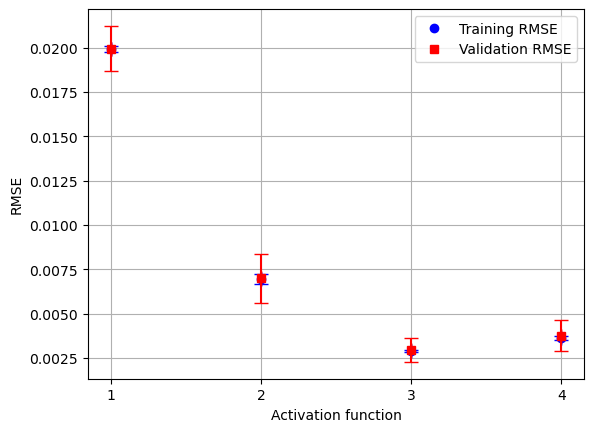

In [37]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

activation = [1, 2, 3, 4]
plt.plot(
    activation,
    train_mean,
    marker="o",
    color="blue",
    linestyle="None",
    label="Training RMSE",
)
plt.errorbar(
    activation,
    train_mean,
    train_std,
    train_std,
    capsize=5,
    color="blue",
    linestyle="None",
)
plt.plot(
    activation,
    test_mean,
    marker="s",
    color="red",
    linestyle="None",
    label="Validation RMSE",
)
plt.errorbar(
    activation, test_mean, test_std, test_std, capsize=5, color="red", linestyle="None"
)
plt.grid()
plt.legend(loc="upper right")
plt.xlabel("Activation function")
plt.ylabel("RMSE")
plt.xticks(activation)
plt.show()

The activation functions with the best performance are the `tanh` and `relu` functions. For our model we used the `relu` function, which means we have already made a good choice and we will leave it that way.

#### Grid search

Above we tested each parameter individually. This may not be the best way as there may be a dependency between the different parameters. The best way would be to test all the parameters at the same time. This can be done using an approach called **grid search**. However, we will not use it here.

### Final model

When we are satisfied with our model evaluation and selection, we can define a final model and train it on the entire training data set. As mentioned before, the only thing we will change is the network layout.

#### Model definition

In [38]:
mlp = MLPRegressor(
    hidden_layer_sizes=(100,),
    activation="relu",
    alpha=0.0001,
    batch_size=200,
    max_iter=200,
    random_state=0,
)

#### Model training

In [39]:
mlp.fit(X_train, y_train)

MLPRegressor(batch_size=200, random_state=0)

#### Final model evaluation

In [40]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, mlp.predict(X_test), squared=False)

/opt/anaconda3/envs/jupyter_book_ml/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0.0439057881042131

Our final model evaluation shows an RMSE of 0.04, which is slightly better than the 0.055 from our first attempt.

**Now we have our final model and could use it to predict temperature values for new data. However,...**

### A good model might not do what we think it does...

In our model, we used vapor pressure and relative humidity, among other things, to predict temperature. Let us add some physical background here. Relative humidity is defined as the ratio of vapor pressure to saturation vapor pressure. From the relative humidity and the vapor pressure, we can calculate the saturation vapor pressure. The saturation vapor pressure in turn has a relationship to temperature called the Magnus formula. This is not a linear relationship, but as we know, neural networks can model non-linear relationships.

**Thus, the model probably models only the Magnus formula and simply ignores all other data.**

We can test this by removing the vapor pressure or the relative humidity from the data and train the model again.

In [41]:
from sklearn.model_selection import train_test_split

# drop vapor pressu
X, y = data.drop(columns=["temp", "vapor_pres"]), data["temp"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [42]:
mlp.fit(X_train, y_train)

MLPRegressor(batch_size=200, random_state=0)

In [43]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, mlp.predict(X_test), squared=False)

/opt/anaconda3/envs/jupyter_book_ml/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


6.2498239366873385

Obviously, the performance drops dramatically.

**So we conclude that our model did a good job, but it might have been easier to just use our physical knowledge in the first place.**

In [50]:
from IPython.display import IFrame

IFrame(
    src="../citations/citation_Soga.html",
    width=900,
    height=200,
)